In [26]:
import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [27]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [ ]:
sol = data.load_asset('BTCUSDT', sampling='1d')
sol = data.add_fear_and_greed(sol)
# Restrict data after 2022
sol = sol[sol.index >= '2022-01-01']
sol.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1.212145e+08,194010,8946.955535,6.459779e+07,37.0,Fear
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,2.259823e+08,302667,15141.611340,1.070608e+08,39.0,Fear
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,4.950986e+08,519854,35595.496273,2.577131e+08,38.0,Fear
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,2.198742e+08,279370,16369.382248,1.200351e+08,38.0,Fear
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,2.848487e+08,329209,19455.369564,1.446001e+08,39.0,Fear


In [29]:
sol.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'F&G', 'F&G category'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()

    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df


In [31]:
sol = add_technical_features(sol)
sol.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope
Open time,,,,,,,,,,,,,,
2020-01-15,8821.41,84816.297606,Neutral,0.001293,0.036403,76.896910,0.0,1620.56,352.48,101.84,-250.64,0.501230,0.001027,118.805231
2020-01-16,8720.01,51991.074284,Greed,-0.011561,0.034638,73.142915,0.0,1754.30,273.81,39.80,-234.01,0.500086,0.001202,109.919824
2020-01-17,8913.28,70897.737377,Neutral,0.021922,0.033046,75.589051,0.0,1568.32,369.21,321.50,-47.71,0.509868,0.001074,111.347956
2020-01-18,8915.96,38294.746545,Neutral,0.000301,0.033074,75.622208,0.0,1561.85,182.50,75.61,-106.89,0.507244,0.001344,106.260593
2020-01-19,8701.70,70676.889259,Neutral,-0.024325,0.034479,67.704574,0.0,1342.95,732.98,283.89,-449.09,0.476452,0.000987,88.339209


In [32]:
sol.columns

Index(['Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
       'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume',
       'slope'],
      dtype='object')

In [33]:
def prep_data(df, sequence_length=60, test_size=0.2):
    # 1) include 'Close' since that's what we'll predict
    features = [
        'Close',      # ← our prediction target
        'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO',
        'buy_pressure_ratio', 'trades_per_volume', 'slope'
    ]
    
    # 2) split numeric vs cat\egorical
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    
    # 3) combine & scale
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all.values)
    feature_names = df_all.columns.tolist()
    
    # 4) build sequences for time-series
    target_idx = feature_names.index('Close')
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        # y is the scaled Close price at time i (next day)
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)
    
    # 5) train/test split (preserving time order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    return (X_train, X_test, y_train, y_test), scaler



In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ——— Hyperparameters (from Optuna) ———
UNITS_L0      = 147
DROPOUT_L0    = 0.0
LEARNING_RATE = 0.0007280355873484089
OPTIMIZER     = Adam(learning_rate=LEARNING_RATE)
BATCH_SIZE    = 32
MAX_EPOCHS    = 50

def train_lstm_for_asset(df, sequence_length=30, test_size=0.19525547445255476):
    # … prep_data as before …
    (X_train, X_val, y_train, y_val), scaler = prep_data(
        df, sequence_length=sequence_length, test_size=test_size
    )
    
    # Build the model
    model = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(UNITS_L0, return_sequences=False, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    
    # *** instantiate a new optimizer here, not reuse a global one ***
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=1
    )
    
    return model, scaler, history, (X_val, y_val)

# Example usage for any asset DataFrame `asset_df`:
# model, scaler, history, (X_val, y_val) = train_lstm_for_asset(asset_df)

# And to plot predictions vs actual:
# preds = model.predict(X_val).flatten()
# plt.figure(figsize=(10,5))
# plt.plot(y_val,  label='Actual Close (scaled)')
# plt.plot(preds, label='Predicted Close (scaled)')
# plt.legend()
# plt.title("LSTM Forecast (Scaled)")
# plt.show()

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0431 - val_loss: 0.0464
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0161
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9750e-04 - val_loss: 0.0057
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6440e-04 - val_loss: 0.0039
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5359e-04 - val_loss: 0.0023
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9611e-04 - val_loss: 0.0018
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1271e-04 - val_loss: 0.0023
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3640e-04 - val_loss: 0.0021
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5666e-04 - val_loss: 0.0019
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2008e-04 - val_loss: 0.0010
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4139e-04 - val_loss: 0.0023
Epoch 12/50
47/47 ━━━━━━━━━

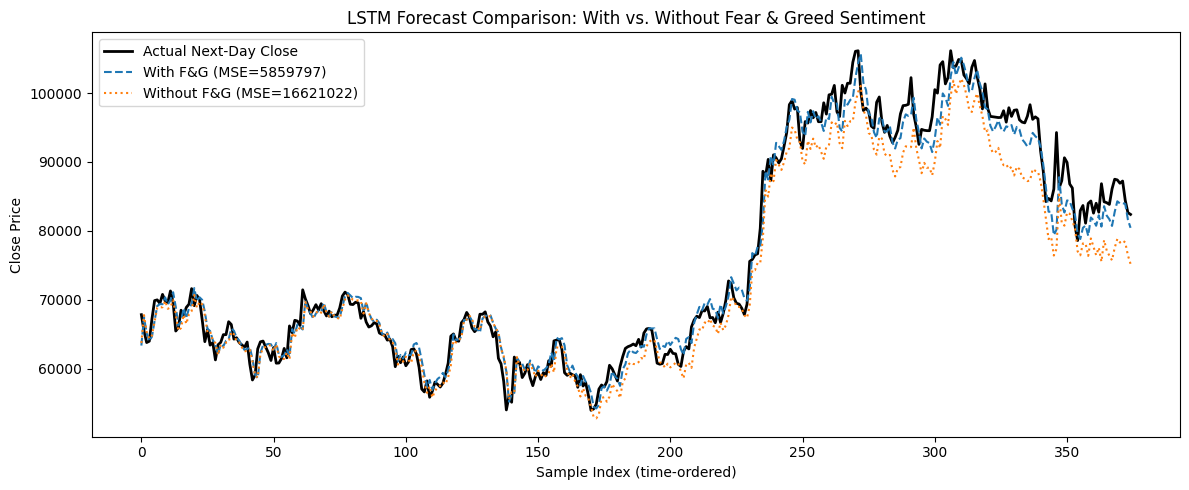

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- 1) Prepare target as next-day close ---
sol['target_close'] = sol['Close'].shift(-1)
sol = sol.dropna(subset=['target_close'])

# --- 2) Fit a dedicated scaler on the target only ---
scaler_y = MinMaxScaler()
scaler_y.fit(sol[['target_close']])

# --- 3) Identify all F&G dummy columns ---
fg_cols = [col for col in sol.columns if col.startswith("FG_cat_")]

# --- 4) Train two LSTMs via your helper function ---
# Replace `sequence_length=30` with whatever you used originally
model_with, scaler_with, hist_with, (X_val_w, y_val_w_scaled) = train_lstm_for_asset(sol, sequence_length=30)

df_noFG = sol.drop(columns=fg_cols)
model_without, scaler_without, hist_without, (X_val_wo, y_val_wo_scaled) = train_lstm_for_asset(df_noFG, sequence_length=30)

# --- 5) Invert scaling back to price units ---
y_val   = scaler_y.inverse_transform(y_val_w_scaled.reshape(-1, 1)).flatten()
pred_w  = scaler_y.inverse_transform(model_with.predict(X_val_w).reshape(-1, 1)).flatten()
pred_wo = scaler_y.inverse_transform(model_without.predict(X_val_wo).reshape(-1, 1)).flatten()

# --- 6) Compute MSE for both models ---
mse_with    = mean_squared_error(y_val, pred_w)
mse_without = mean_squared_error(y_val, pred_wo)

# --- 7) Plot Actual vs. Predicted (with & without F&G) ---
plt.figure(figsize=(12, 5))
plt.plot(y_val,        label=f"Actual Next-Day Close", color="black", linewidth=2)
plt.plot(pred_w,       label=f"With F&G (MSE={mse_with:.0f})", linestyle="--")
plt.plot(pred_wo,      label=f"Without F&G (MSE={mse_without:.0f})", linestyle=":")
plt.xlabel("Sample Index (time-ordered)")
plt.ylabel("Close Price")
plt.title("LSTM Forecast Comparison: With vs. Without Fear & Greed Sentiment")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


